## Import python modules and packages:

In [1]:
%matplotlib inline 

import numpy as np

import seaborn as sns
import math
from math import exp

import matplotlib
import matplotlib.pyplot as plt
from matplotlib import cm
import matplotlib.colors as colors
from matplotlib.colors import rgb_to_hsv, hsv_to_rgb
from matplotlib.colors import LogNorm
import matplotlib.ticker as ticker

import scipy.interpolate as ip

## pip install lic (source: https://lic.readthedocs.io/en/latest/): 
import lic

# Sample python script to create a database using h5py
# http://docs.h5py.org/en/latest/quick.html
# Example : http://docs.h5py.org/en/latest/quick.html
import h5py

#==============================================================================
# Seaborn Settings
#==============================================================================

plt.style.use('seaborn')

sns.set(style='ticks', context='paper', font_scale=3)
sns.set_style('ticks', {'xtick.major.size':8, 'ytick.major.size':8, 'xtick.minor.size':3, 'ytick.minor.size':3})
sns.set_style({'xtick.top':True,'ytick.right': True})


#==============================================================================

matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'


## LIC plot example:

generate lics: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:02<00:00,  3.42it/s]
lic | 2023-08-04 16:59:28,647 | WARNING  | Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


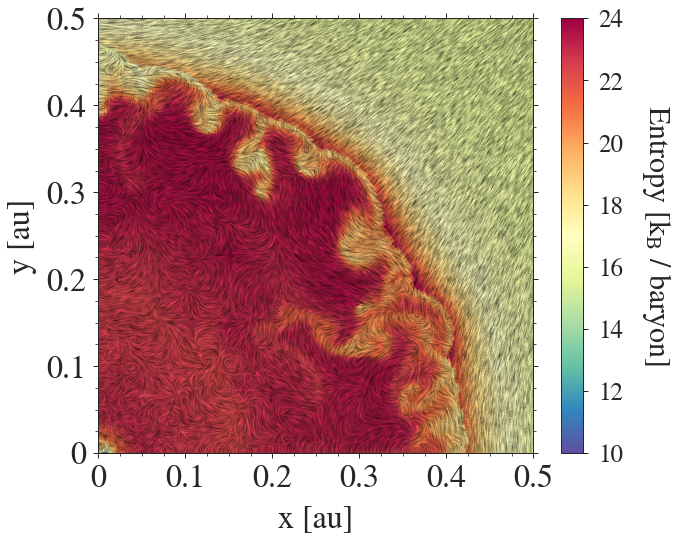

In [2]:
## Data can be downloaded from https://plg.physlab.uni-due.de/tara-database/ 

wdir_database = "./tara/data-2D/"

fig, ax = plt.subplots(figsize=(10, 8))

for mass in ["1"]:
    dataset = h5py.File(wdir_database+'2D_dataset_m%s.hdf5' % (mass), 'r')
    sorted_key = sorted(list(dataset.keys()), key=float)
    key = float(list(sorted_key)[-1])
    for n in [key]:
        radius = np.array(dataset.get("%s/radius" % (n)))
        theta = np.array(dataset.get("%s/theta" % (n)))

        x = radius * (np.sin(theta))
        y = radius * (np.cos(theta))
        
        gas_temperature = np.array(dataset.get("%s/gas_temperature" % (n)))
        rho = np.array(dataset.get("%s/gas_density" % (n)))
        entropy = np.array(dataset.get("%s/entropy" % (n)))

        vx = np.array(dataset.get("%s/radial_velocity" % (n)))
        vy = np.array(dataset.get("%s/angular_velocity" % (n)))

        velx1 = ( np.sin(theta)*vx + (np.cos(theta)*vy ))
        velx2 = ( np.cos(theta)*vx - (np.sin(theta)*vy ))

        ## Flatten arrays
        points = np.dstack((x.ravel(), y.ravel()))[0]
        vx_at_points = velx1.ravel()
        vy_at_points = velx2.ravel()
        temp_at_points = gas_temperature.ravel()
        rho_at_points = rho.ravel()
        entropy_at_points = entropy.ravel()
        
        
        ## Resample data onto Cartesian grid
        
        ## Set outer radius limit:
        rzoom = 0.5
        
        ## Resolution for LIC: 
        resolution = 1024   #512

       
        LIC_grid_x, LIC_grid_y = np.meshgrid(np.linspace(0, rzoom, resolution), np.linspace(0, rzoom, resolution))
        LIC_grid_vx = ip.griddata(points, vx_at_points, (LIC_grid_x, LIC_grid_y), method='nearest')
        LIC_grid_vy = ip.griddata(points, vy_at_points, (LIC_grid_x, LIC_grid_y), method='nearest')
        LIC_grid_vmag = np.sqrt(LIC_grid_vx**2 + LIC_grid_vy**2)    
        LIC_grid_temp = ip.griddata(points, temp_at_points, (LIC_grid_x, LIC_grid_y), method='nearest')
        LIC_grid_rho = ip.griddata(points, rho_at_points, (LIC_grid_x, LIC_grid_y), method='nearest')
        LIC_grid_entropy = ip.griddata(points, entropy_at_points, (LIC_grid_x, LIC_grid_y), method='nearest')
     
    
        ## LIC (source: https://lic.readthedocs.io/en/latest/): 
        lic_res = lic.lic(LIC_grid_vx, LIC_grid_vy, length=20)

#         plt.imshow(lic_res, vmax=0.8, origin='lower', cmap='gray')
        

        ## Apply colormap to property and multiply by LIC: 

        colormap = cm.get_cmap('Spectral_r', 256)

        ## Set property to be plotted: 
        val = LIC_grid_entropy
        
        
        vmin = val.min() 
        vmax = val.max()
        
#         val = np.log(val)
#         if False:
#             vmin = np.percentile(val, 10)
#             vmax = np.percentile(val, 90)
#         else:
#             vmin = val.min()
#             vmax = val.max()

        lin_val = (val - vmin) / (vmax - vmin)
        
        log10_val = np.log10(val)
        log_vmin = log10_val.min()
        log_vmax = log10_val.max()

        log_val = (log10_val - log_vmin) / (log_vmax - log_vmin)

        
        ## Set linear (lin_val) or log (log_val) scale as required: 
        rgb_val = colormap(lin_val) 

        hsv_val = rgb_to_hsv(rgb_val[:,:,:3])
        hsv_val[:,:,2] *= 1.5 * lic_res
        rgb_val = hsv_to_rgb(hsv_val)
        
        plt.imshow(rgb_val, origin='lower')


## Colorbar:

# norm = colors.LogNorm(vmin=np.min(val), vmax=np.max(val))
# norm = colors.Normalize(vmin=np.min(val), vmax=np.max(val))

## Limits for entropy:
norm = colors.Normalize(vmin=10, vmax=24)

sm = plt.cm.ScalarMappable(cmap='Spectral_r', norm=norm)
cbar = plt.colorbar(sm, orientation='vertical')
cbar.ax.tick_params(labelsize=25, size=5, width=1, pad=10)
# cbar.set_label(r'Gas temperature [K]', rotation=270, labelpad=50, fontsize=30)

cbar.set_label(r'Entropy [$\mathrm{k}_{\mathrm{B}}$ / baryon]', rotation=270, labelpad=50, fontsize=30)
labels = [10, 12, 14, 16, 18, 20, 22, 24]
cbar.set_ticks(labels)
cbar.set_ticklabels(labels)

        
ax.set_xlabel('x [au]', fontsize=32)
ax.set_ylabel('y [au]', fontsize=32)

ax.xaxis.labelpad = 10
ax.yaxis.labelpad = 10 

plt.minorticks_on()

ax.tick_params(labelsize=32)

## Resetting axis ticks and labels:
scale = resolution/rzoom
positions = [0, 0.1*scale, 0.2*scale, 0.3*scale, 0.4*scale, 0.5*scale]
ax.xaxis.set_major_locator(ticker.FixedLocator(positions))
ax.yaxis.set_major_locator(ticker.FixedLocator(positions))

plt.xlim(0, resolution)
plt.ylim(0, resolution)

ax.set_xticklabels([0, 0.1, 0.2, 0.3, 0.4, 0.5])
ax.set_yticklabels([0, 0.1, 0.2, 0.3, 0.4, 0.5])


# fig.savefig('lic.png', dpi=100, transparent=False, bbox_inches='tight')

plt.show()
        